# Aprendizaje automático y aplicaciones

---
$A^3$ @ FI-UNER : 2021

## Guía de trabajos prácticos del Encuentro 2

### Sobre los ejercicios
Debe entregar esta notebook completa con un informe. Puede agregar celdas en esta misma notebook para realizar el mismo. Agreguen comentarios en el código entregado para facilitar la lectura y entendimiento.

Recuerde que la **evaluación se hará en base a las guías resueltas** de cada clase y que cada una de ellas debe resolverse **de forma individual**.

La primer parte de esta notebook se presenta el problema a resolver y están ya funcionando los pasos básicos de preparación de datos. Ustedes deberán completar las regiones del código donde hay comentarios con **TODO**, usando lo visto en este encuentro. Una vez entrenados y evaluados los modelos, al final tendrán una celda para graficar los resultados y detallar conclusiones

### Detección de pre-miRNAs
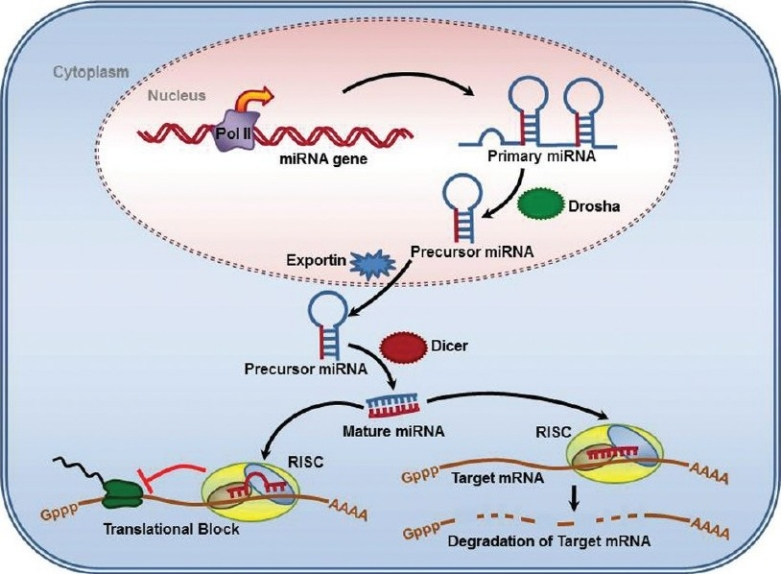
Identificar potenciales secuencias pre-miRNAs en genomas completos es una tarea desafiante. Estas secuencias se pliegan conformando horquillas, pero no todas las horquillas llegan a ser pre-miRNAs. Muchas de ellas se pueden identificar por alineamiento de secuencias (Blast) con miRNAs conocidos, pero muchas otras pueden tener secuencias diferentes y aún asi conformar pre-miRNAs.   

Mediante un proceso de extracción de características podemos generar variables que describen a estas horquillas, tales como energía libre liberada, cantidad de nucleótidos formando ciertos patrones, etc. Este conjunto de características demostró una gran capacidad discriminativa para este problema. En este caso, el objetivo es que los patrones obtenidos reflejen las posibilidades de la secuencia sin depender de un alineamiento exacto con miRNAs conocidos, y de esta forma encontrar casos no homólogos.

En este ejercicio vamos a comparar diferentes clasificadores para esta tarea. Usaremos un dataset que contiene todas las horquillas de *A. thaliana* con sus características extraídas. Las etiquetas son binarias: 
- clase positiva (1): La secuencia es un pre-miRNA conocido en base a miRBase v21;
- clase negativa (0): La secuencia no tiene una función conocida*. 

Más detalles en [éste artículo](https://www.sciencedirect.com/science/article/pii/S2352340919305633?via%3Dihub)

*Estrictamente la clase negativa es una clase "desconocida", porque no sabemos si puede ser positiva o negativa. Por tanto, es un problema de una clase (y no binario). Sin embargo, se puede plantear como un problema de clasificación binaria si consideramos que la mayoría de las clases desconocidas no serán nunca clase positiva.


## Preparación del dataset
Descargamos los datos del repositorio público y lo cargamos en la notebook

**IMPORTANTE**: Los comandos de la siguiente celda funcionan si se utiliza desde Colab. Si usan la notebook de forma local puede no funcionar dependiendo de la configuración de base. Se pueden llamar estos comandos desde la consola o directamente descargar el archivo del link y guardarlo en la misma carpeta donde se encuentra la notebook

In [1]:
!wget -q --show-progress https://sourceforge.net/projects/sourcesinc/files/mirdata/features/ath.zip/download
!unzip download
!rm download

download            100%[===================>] 185.71M  17.2MB/s    in 11s     
Archive:  download
  inflating: ath.csv                 


In [2]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 

data = pd.read_csv("ath.csv")
data

,sequence_names,nt_proportion0,nt_proportion1,nt_proportion2,nt_proportion3,dinucleotide_proportion0,dinucleotide_proportion1,dinucleotide_proportion2,dinucleotide_proportion3,dinucleotide_proportion4,dinucleotide_proportion5,dinucleotide_proportion6,dinucleotide_proportion7,dinucleotide_proportion8,dinucleotide_proportion9,dinucleotide_proportion10,dinucleotide_proportion11,dinucleotide_proportion12,dinucleotide_proportion13,dinucleotide_proportion14,dinucleotide_proportion15,gc_content,gc_ratio,sequence_length,stem_number,avg_bp_stem,longest_stem_length,terminal_loop_length,bp_number,dP,bp_proportion0,bp_proportion1,bp_proportion2,bp_proportion_stem0,bp_proportion_stem1,bp_proportion_stem2,triplets0,triplets1,triplets2,triplets3,triplets4,triplets5,triplets6,triplets7,triplets8,triplets9,triplets10,triplets11,triplets12,triplets13,triplets14,triplets15,triplets16,triplets17,triplets18,triplets19,triplets20,triplets21,triplets22,triplets23,triplets24,triplets25,triplets26,triplets27,triplets28,triplets29,triplets30,triplets31,mfe,efe,ensemble_frequency,diversity,mfe_efe_difference,dQ,dG,mfei1,mfei2,mfei4,CLASS
0,1_dna_sm:chromosome_chromosome:TAIR10:1:1:3042...,0.257310,0.192982,0.233918,0.315789,0.052941,0.058824,0.082353,0.064706,0.052941,0.023529,0.011765,0.100000,0.064706,0.047059,0.052941,0.070588,0.088235,0.058824,0.088235,0.082353,0.426901,1.212121,171,10,6.700000,13,6,67,0.391813,0.522388,0.373134,0.104478,0.052239,0.037313,0.010448,0.155280,0.124224,0.136646,0.180124,0.018634,0.012422,0.024845,0.049689,0.012422,0.012422,0.012422,0.018634,0.018634,0.000000,0.018634,0.012422,0.037267,0.012422,0.037267,0.024845,0.0,0.0,0.000000,0.0,0.018634,0.018634,0.000000,0.012422,0.000000,0.000000,0.018634,0.012422,-80.0,-81.78,0.055466,8.86,0.010409,0.129659,-0.467836,-1.095890,-0.046784,-1.194030,1
1,1_dna_sm:chromosome_chromosome:TAIR10:1:1:3042...,0.265306,0.214286,0.204082,0.316327,0.134021,0.041237,0.072165,0.020619,0.030928,0.051546,0.020619,0.103093,0.072165,0.010309,0.072165,0.051546,0.030928,0.113402,0.041237,0.134021,0.418367,0.952381,98,5,8.400000,11,3,42,0.428571,0.523810,0.380952,0.095238,0.104762,0.076190,0.019048,0.153846,0.131868,0.175824,0.197802,0.032967,0.000000,0.032967,0.043956,0.032967,0.032967,0.000000,0.043956,0.000000,0.000000,0.000000,0.000000,0.043956,0.032967,0.010989,0.032967,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-53.0,-53.70,0.323430,1.93,0.007143,0.037328,-0.540816,-1.292683,-0.108163,-1.261905,1
2,1_dna_sm:chromosome_chromosome:TAIR10:1:1:3042...,0.295597,0.182390,0.188679,0.333333,0.101266,0.031646,0.056962,0.107595,0.037975,0.031646,0.025316,0.082278,0.088608,0.018987,0.037975,0.044304,0.063291,0.101266,0.069620,0.101266,0.371069,1.034483,159,8,7.375000,12,3,59,0.371069,0.542373,0.355932,0.101695,0.067797,0.044492,0.012712,0.157895,0.105263,0.111842,0.164474,0.039474,0.026316,0.019737,0.019737,0.026316,0.019737,0.006579,0.013158,0.013158,0.000000,0.000000,0.026316,0.006579,0.000000,0.046053,0.059211,0.0,0.0,0.000000,0.0,0.006579,0.013158,0.006579,0.013158,0.039474,0.013158,0.006579,0.039474,-65.0,-67.09,0.033536,7.47,0.013145,0.117231,-0.408805,-1.101695,-0.051101,-1.101695,1
3,1_dna_sm:chromosome_chromosome:TAIR10:1:1:3042...,0.375887,0.184397,0.205674,0.234043,0.150000,0.050000,0.042857,0.135714,0.107143,0.021429,0.035714,0.014286,0.057143,0.057143,0.057143,0.035714,0.057143,0.057143,0.071429,0.050000,0.390071,1.115385,141,3,15.000000,21,6,45,0.319149,0.555556,0.400000,0.044444,0.185185,0.133333,0.014815,0.106870,0.091603,0.099237,0.114504,0.038168,0.038168,0.007634,0.045802,0.022901,0.015267,0.007634,0.015267,0.030534,0.000000,0.022901,0.007634,0.030534,0.007634,0.045802,0.038168,0.0,0.0,0.000000,0.0,0.045802,0.000000,0.007634,0.007634,0.076336,0.030534,0.030534,0.015267,-51.8,-53.31,0.086667,13.50,0.010709,0.298322,-0.367376,-0.941818,-0.122459,-1.151111,1
4,1_dna_sm:chromosome_chromosome:TAIR10:1:1:3042...,0.295652,0.182609,0.182609,0.3391

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
data.describe()

,nt_proportion0,nt_proportion1,nt_proportion2,nt_proportion3,dinucleotide_proportion0,dinucleotide_proportion1,dinucleotide_proportion2,dinucleotide_proportion3,dinucleotide_proportion4,dinucleotide_proportion5,dinucleotide_proportion6,dinucleotide_proportion7,dinucleotide_proportion8,dinucleotide_proportion9,dinucleotide_proportion10,dinucleotide_proportion11,dinucleotide_proportion12,dinucleotide_proportion13,dinucleotide_proportion14,dinucleotide_proportion15,gc_content,gc_ratio,sequence_length,stem_number,avg_bp_stem,longest_stem_length,terminal_loop_length,bp_number,dP,bp_proportion0,bp_proportion1,bp_proportion2,bp_proportion_stem0,bp_proportion_stem1,bp_proportion_stem2,triplets0,triplets1,triplets2,triplets3,triplets4,triplets5,triplets6,triplets7,triplets8,triplets9,triplets10,triplets11,triplets12,triplets13,triplets14,triplets15,triplets16,triplets17,triplets18,triplets19,triplets20,triplets21,triplets22,triplets23,triplets24,triplets25,triplets26,triplets27,triplets28,triplets29,triplets30,triplets31,mfe,efe,ensemble_frequency,diversity,mfe_efe_difference,dQ,dG,mfei1,mfei2,mfei4,CLASS
count,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00
mean,0.31,0.17,0.18,0.33,0.11,0.05,0.06,0.09,0.06,0.03,0.02,0.06,0.07,0.03,0.03,0.06,0.08,0.06,0.07,0.12,0.35,1.26,82.17,3.25,7.88,7.53,7.73,23.84,0.29,0.54,0.32,0.14,0.19,0.11,0.05,0.12,0.06,0.09,0.15,0.03,0.02,0.02,0.04,0.02,0.01,0.01,0.01,0.02,0.01,0.01,0.02,0.03,0.02,0.03,0.04,0.00,0.00,0.00,0.00,0.02,0.01,0.01,0.02,0.07,0.03,0.02,0.06,-15.95,-17.50,0.12,11.07,0.02,0.39,-0.20,-0.56,-0.07,-0.67,0.00
std,0.08,0.06,0.06,0.08,0.06,0.03,0.03,0.04,0.03,0.03,0.02,0.03,0.03,0.02,0.03,0.03,0.04,0.03,0.03,0.06,0.09,0.86,16.04,1.08,2.61,2.15,5.50,5.84,0.05,0.13,0.13,0.08,0.09,0.08,0.03,0.05,0.03,0.04,0.05,0.02,0.02,0.02,0.02,0.02,0.01,0.02,0.02,0.02,0.01,0.01,0.02,0.02,0.02,0.02,0.02,0.00,0.00,0.01,0.00,0.02,0.01,0.01,0.02,0.06,0.03,0.02,0.05,6.61,6.67,0.11,6.49,0.01,0.22,0.07,0.23,0.04,0.20,0.01
min,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,50.00,1.00,4.00,4.00,3.00,4.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-472.10,-473.32,0.00,0.18,0.00,0.00,-1.01,-43.80,-1.01,-2.21,0.00
25%,0.26,0.13,0.14,0.28,0.07,0.03,0.04,0.06,0.04,0.01,0.00,0.04,0.04,0.01,0.01,0.04,0.05,0.04,0.05,0.08,0.29,0.79,70.00,3.00,6.25,6.00,4.00,20.00,0.26,0.45,0.23,0.08,0.13,0.07,0.03,0.08,0.04,0.07,0.11,0.02,0.00,0.01,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.01,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.03,0.00,0.00,0.02,-19.40,-20.99,0.04,6.28,0.01,0.23,-0.24,-0.65,-0.08,-0.80,0.00
50%,0.31,0.17,0.18,0.33,0.10,0.05,0.06,0.09,0.06,0.03,0.02,0.06,0.06,0.03,0.03,0.05,0.07,0.06,0.06,0.11,0.36,1.08,79.00,3.00,7.33,7.00,6.00,23.00,0.29,0.54,0.32,0.13,0.17,0.10,0.04,0.11,0.06,0.09,0.14,0.03,0.02,0.02,0.04,0.01,0.00,0.00,0.01,0.02,0.01,0.00,0.02,0.03,0.01,0.03,0.04,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.02,0.06,0.03,0.01,0.05,-15.10,-16.61,0.09,9.65,0.02,0.35,-0.19,-0.54,-0.06,-0.65,0.00
75%,0.3

In [4]:
data["CLASS"].value_counts()

0    1355359
1        304
Name: CLASS, dtype: int64

Como el desbalance es muy alto y son muchas horquillas, empezaremos con un caso más manejable, muestreando 5000 ejemplos

In [5]:
n_casos = 5000

# Definimos una probabilidad de muestreo de forma tal que sea mucho mas probable
# muestrear un caso positivo que uno negativo
ratio = sum(data["CLASS"])/len(data)
data["weight"] = data["CLASS"].apply(lambda x: ratio if x==0 else 1)
data = data.sample(n=n_casos, weights=data["weight"])

data["CLASS"].value_counts()

0    4696
1     304
Name: CLASS, dtype: int64

Organizamos los datos en X, y

In [6]:
X = data.drop(columns=["sequence_names", "CLASS", "weight"]).values
y = data["CLASS"].values
print(X.shape, y.shape)

(5000, 77) (5000,)


Haremos una validación cruzada de 5 particiones, las hacemos acá para que todas las pruebas se corran con los mismo datos. Como los datos estan muy desbalanceados, haremos una partición *estratificada*: cada partición tendrá la misma proporción de clases que los datos originales 

In [8]:
from sklearn.model_selection import StratifiedKFold

generador_particiones = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

particiones = list(generador_particiones.split(X, y))

# Ahora "particiones" es una lista de la forma [(train_ind1, test_ind1), (train_ind2, test_ind2), ...]

# Convertimos a una lista para usar la primer parte, pero sino 
# se puede usar así:

# for train_ind, test_ind in generador_particiones.split(X, y):
#   procesamos cada partición  
#   ...
#     


## Elección de modelos e hiperparámetros 

En esta sección se propone evaluar al menos dos clasificadores diferentes de los vistos en clase (por ejemplo SVM y random forest), explorando sus hiperparámetros con la primer partición de entrenamiento.   

Este es un proceso que se puede hacer internamente en la validación cruzada (y de forma automática), pero en este caso lo haremos así para poder analizar los resultados y que el procedimiento no consuma demasiado tiempo.

Revisando la documentación, encontrarán que cada método tiene muchos parametros que pueden modificarse, aunque no todos ellos afectan de igual forma al error de clasificación. Por ejemplo,

- SVM: El tipo de kernel y sus parámetros y el valor C
- RF: La cantidad de árboles y la cantidad de características a utilizar en cada arbol (max_features)  

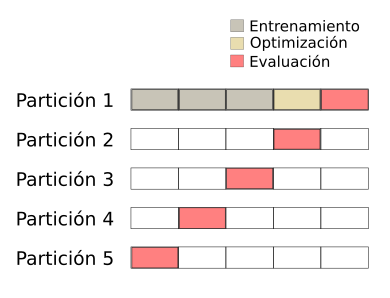

**Importante**: No usar la partición de evaluación para decidir el mejor conjunto 

In [ ]:
from sklearn.model_selection import train_test_split
# definimos la métrica para evaluar los modelos
from sklearn.metrics import f1_score

# Cargamos los datos de la primer partición de entrenamiento, para separarlos 
# en entrenamiento y optimizacion
train_ind, _ = particiones[0] # notar que "test_ind" es "_" porque no lo vamos a usar

# Ahora tendremos las particiones del esquema de arriba 
Xtrain, Xoptim, ytrain, yoptim = train_test_split(X[train_ind, :], y[train_ind], test_size=.2, stratify=y[train_ind])

print("Datos de entrenamiento", Xtrain.shape, "| datos de optimización:", Xoptim.shape)
print(f"Entrenamiento: {len(ytrain)} ({np.sum(ytrain==1)} positivos)")
print(f"Optimización: {len(yoptim)} ({np.sum(yoptim==1)} positivos)")

En la siguiente celda hacer la busqueda de hiperparámetros para un modelo

In [ ]:
# TODO: Importar la función del clasificador a usar

# TODO completar la lista siguiente con los parámetros a explorar 
param_list = # [...] 
# Si se va a explorar más de un hiperparámetro a la vez, se puede hacer una lista 
# combinando ambos:
# param_list = [(p1, q1), (p2, q2), ...]
# O bien hacer dos ciclos for, uno por cada hiperparámetro

for p in param_list:
    
    # TODO: Instanciar el modelo con el parámetro p
    
    # TODO: Entrenar el modelo

    # TODO: generar una predicción para Xoptim   
    pred = #...
    f1 = f1_score(yoptim, pred)
     
    print("nombre_modelo", p, f1)

Repetir la celda anterior para cada modelo a evaluar

## Validación cruzada

A partir del análisis anterior tendremos un conjunto de parámetros óptimo para cada modelo. Como el objetivo es comparar clasificadores, ahora haremos la validación cruzada para tener una estimación insesgada del funcionamiento de cada clasificador en este dataset. 

In [ ]:
# TQDM muestra una barra de avance a medida que pasan las iteraciones 
from tqdm import tqdm

# Vamos a analizar varias métricas
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

results = []

for train_ind, test_ind in tqdm(particiones): 
    for nombre_modelo in ["modelo_1", "modelo_2"]: # TODO completar con todos los modelos a usar
            
        if nombre_modelo == "modelo_1":
            # TODO: instanciar el modelo con los hiperparámetros que dieron mejor en el análisis previo
            modelo = # ...
        if nombre_modelo == "modelo_2":
            # TODO: instanciar el modelo con los hiperparámetros que dieron mejor en el análisis previo
            modelo = # ...

        # notar que ahora X[train_ind, :] contiene a Xtrain y Xoptim del punto 
        # anterior
        modelo.fit(X[train_ind, :], y[train_ind])

        # La siguietne predicción se hace sobre datos que no fueron vistos antes
        pred = modelo.predict(X[test_ind, :])

        results.append([nombre_modelo,
                        accuracy_score(y[test_ind], pred),
                        f1_score(y[test_ind], pred),
                        recall_score(y[test_ind], pred),
                        precision_score(y[test_ind], pred)])

results = pd.DataFrame(results, columns=["modelo", "acc", "f1", "pre", "rec"])
results

## Comparación final
Con la lista de resultados podemos comparar los modelos en términos de las diferentes métricas de error
(con los resultados ya generados en la celda anterior, en la siguiente no es necesario modificar nada)

In [ ]:
import seaborn

fig, ax = plt.subplots(1, 4, figsize=(12, 5))

for k, metric in enumerate(["acc", "pre", "rec", "f1"]):
    seaborn.boxplot(data=results, y=metric, x="modelo", ax=ax[k])
    ax[k].set_ylim([0, 1])
plt.tight_layout()

# Otras aplicaciones de aprendizaje automático

Te proponemos ahora pensar en tu propia área de aplicación. 
- ¿En qué podrías aplicar modelos de ML para clasificación, regresión o agrupamiento? 